In [28]:
import numpy as np
import math as math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data= np.loadtxt("boston.csv",delimiter=",")

In [3]:
boston50=np.copy(data)
boston75=np.copy(data)

In [4]:
median=np.median(boston50[:,-1])
boston50[boston50[:,-1]<median,-1]=-1
boston50[boston50[:,-1]>=median,-1]=1

In [5]:
perce=np.percentile(boston75[:,-1],75)
boston75[boston75[:,-1]<perce,-1]=-1
boston75[boston75[:,-1]>=perce,-1]=1

In [6]:
# Decision Tree 

In [9]:
def split_node(X,column, val):
    set_true=X[X[:,column]>=val,:]
    set_false= X[X[:,column]<val,:]
    return set_true, set_false

In [10]:
def entropy(X):
    entropy=0
    if X.shape[0]!=0: 
        for x in np.unique(X[:,-1]):
            p=float(np.sum(X[:,-1]==x))/X.shape[0]
            entropy += p * np.log2(p) 
    return -1.0 * entropy

In [11]:
class node:
    def __init__(self, col=None, val=None, is_Leaf = False, clas=None, true_branch=None, false_branch=None):
        self.col=col
        self.val=val
        self.is_Leaf = is_Leaf
        self.clas=clas
        self.true_branch=true_branch
        self.false_branch=false_branch

In [12]:
def decision_tree_node(X):
    cols=range(0,X.shape[1]-1)
    entropy_X= entropy(X)
    attr, threshold, best_entropy = None, None, 1e30
    for col in cols:
        entropy_p = 0.0
        if np.unique(X[:,col]).shape[0]!=2:
            for p in [10,20,30,40,50,60,70,80,90]:
                val=np.percentile(X[:,col],p)
                set_true, set_false = split_node(X,col,val)
                entropy_true= entropy(set_true)
                entropy_false= entropy(set_false)
                entropy_p=(float(set_true.shape[0])/X.shape[0])*entropy_true +(float(set_false.shape[0])/X.shape[0])*entropy_false
                if entropy_p < best_entropy:
                    best_entropy = entropy_p
                    attr = col
                    threshold = val
        else:
            val=1.0
            set_true, set_false = split_node(X,col,val)
            entropy_true= entropy(set_true)
            entropy_false= entropy(set_false)
            entropy_p=(float(set_true.shape[0])/X.shape[0])*entropy_true + (float(set_false.shape[0])/X.shape[0])*entropy_false
            if entropy_p < best_entropy:
                best_entropy = entropy_p
                attr = col
                threshold = val
    return attr, threshold

In [13]:
def decision_tree(X,depth, max_depth):
    if depth == max_depth:
        value, count = np.unique(X[:,-1], return_counts = True)
        return node(is_Leaf=True,clas=value[np.argmax(count)])
    attribute, threshold = decision_tree_node(X)
    X_true, X_false = split_node(X, attribute, threshold)
    cur_node = node(attribute, threshold, False, -1)
    if X_true.shape[0]>0:
        cur_node.true_branch = decision_tree(X_true, depth +1, max_depth)
    if X_false.shape[0]>0:
        cur_node.false_branch = decision_tree(X_false, depth + 1, max_depth)
    return cur_node

In [14]:
def classify(X,tree):
    if tree.is_Leaf==True:
        return tree.clas
    else:
        if isinstance(X[:,tree.col][0],int) or isinstance(X[:,tree.col][0],float):
            if X[:,tree.col]>=tree.val:
                if tree.true_branch is not None:
                    return classify(X,tree.true_branch)
                if tree.true_branch is None:
                    return classify(X,tree.false_branch)
            elif X[:,tree.col]<tree.val: 
                if tree.false_branch is not None:
                    return classify(X,tree.false_branch)
                if tree.false_branch is None:
                    return classify(X,tree.true_branch)
        else:
            if X[:,tree.col]==tree.val:
                return classify(X,tree.true_branch)
            else:
                return classify(X,tree.false_branch)

In [15]:
def bootstrap_sample(X, seed):
    np.random.seed(seed)
    return list(np.random.choice(a=X.shape[0],size=X.shape[0], replace=True))

In [16]:
def adaboost(X,B,seeed,depth,max_depth):
    w=np.repeat(1.0/X.shape[0],X.shape[0])
    tree=[]
    alpha=[]
    for i in range(0,B):
        np.random.seed(seeed)
        b=np.random.choice(a=range(0,X.shape[0]),size=X.shape[0],replace=True,p=w)
        boot=X[b,:]
        tree.append(decision_tree(boot,depth,max_depth))
        yhat=map(lambda x: classify(x.reshape(1,13),tree[i]), X[:,0:13])
        error=np.sum(np.multiply(w,yhat!=X[:,-1]))
        if error<0.5:
            alpha.append(0.5*np.log((1-error)/error))
            step1=yhat*X[:,-1]*alpha[i]*(-1.0)
            w= w*np.exp(step1)
            w=w/np.sum(w)
        else:
            w=np.repeat(1.0/X.shape[0],X.shape[0])
            continue
        seeed = seeed + 1
    return alpha,tree

In [17]:
def ada_boost_error(X,tree,alpha):
    G_x=np.zeros((X.shape[0]))
    for i in range(0,len(tree)):
        yhat=map(lambda x: classify(x.reshape(1,13),tree[i]), X[:,0:13])
        G_x=G_x+alpha[i]*np.array(yhat)
    G_x=np.sign(G_x) 
    return np.sum(G_x!=X[:,-1])*1.0/X.shape[0]

In [18]:
def cross_validation(X,k, depth, max_depth,seed,B):
    np.random.shuffle(X)
    index=[]
    accu=np.zeros((2,k))
    for i in range(0,k):
        index.append(range(X.shape[0]*i/k,X.shape[0]*(i+1)/k))
    for i in range(0,len(index)):
        test=np.copy(X[index[i],:])
        train=np.delete(X[:,:],index[i],axis=0)
        alpha,tree=adaboost(train,B,seed,depth,max_depth)
        accu[0,i]=ada_boost_error(train,tree,alpha)
        accu[1,i]=ada_boost_error(test,tree,alpha)
    return accu

In [19]:
accu=[]
for b in range(5,55,5):
    accu.append(cross_validation(boston50,10,0,2,1,b))

In [20]:
accu75=[]
for b in range(5,55,5):
    accu75.append(cross_validation(boston75,10,0,2,1,b))

In [21]:
accu=np.array(accu).reshape(20,10)
a=np.zeros((20,10))
for i in range(0,10):
    a[2*i,:]=accu[[0,2,4,6,8,10,12,14,16,18],i]
    a[2*i+1,:]=accu[[1,3,5,7,9,11,13,15,17,19],i]
print a
train=a[[0,2,4,6,8,10,12,14,16,18],:]
test=a[[1,3,5,7,9,11,13,15,17,19],:]
np.savetxt("Ada_boost_table_50.csv",a,delimiter=",")

In [23]:
print "Boston 50"
print "Train std"
print np.std(train,axis=0)
np.savetxt("train_std.csv",np.std(train,axis=0),delimiter=",")
print "Train mean"
print np.mean(train,axis=0)
np.savetxt("train_mean.csv",np.mean(train,axis=0),delimiter=",")
print "Test std"
print np.std(test,axis=0)
np.savetxt("test_std.csv",np.std(test,axis=0),delimiter=",")
print "Test mean" 
print np.mean(test,axis=0)
np.savetxt("test_mean.csv",np.mean(test,axis=0),delimiter=",")

Boston 50
Train std
[ 0.01817717  0.01255878  0.01552674  0.00873202  0.00693463  0.01234233
  0.0130129   0.01035992  0.00981655  0.00658129]
Train mean
[ 0.13833864  0.10627723  0.08761712  0.07553692  0.06784847  0.05292703
  0.04522701  0.04018604  0.02985975  0.02152063]
Test std
[ 0.03914388  0.05455049  0.03619555  0.04003238  0.04191313  0.03852659
  0.06521064  0.05237337  0.0592619   0.0443537 ]
Test mean
[ 0.17596078  0.16411765  0.14415686  0.13431373  0.13227451  0.13235294
  0.11462745  0.11458824  0.12431373  0.11470588]


In [24]:
accu75=np.array(accu75).reshape(20,10)
a=np.zeros((20,10))
for i in range(0,10):
    a[2*i,:]=accu75[[0,2,4,6,8,10,12,14,16,18],i]
    a[2*i+1,:]=accu75[[1,3,5,7,9,11,13,15,17,19],i]
print a
train75=a[[0,2,4,6,8,10,12,14,16,18],:]
test75=a[[1,3,5,7,9,11,13,15,17,19],:]
np.savetxt("Ada_boost_table_75.csv",a,delimiter=",")

In [25]:
print "Boston 75"
print "Train std"
print np.std(train75,axis=0)
np.savetxt("train_std.csv",np.std(train75,axis=0),delimiter=",")
print "Train mean"
print np.mean(train75,axis=0)
np.savetxt("train_mean.csv",np.mean(train75,axis=0),delimiter=",")
print "Test std"
print np.std(test75,axis=0)
np.savetxt("test_std.csv",np.std(test75,axis=0),delimiter=",")
print "Test mean" 
print np.mean(test75,axis=0)
np.savetxt("test_mean.csv",np.mean(test75,axis=0),delimiter=",")

Boston 75
Train std
[ 0.0082608   0.00745851  0.00976703  0.00877938  0.00947157  0.00845067
  0.01152523  0.00565748  0.00370705  0.00581577]
Train mean
[ 0.08783931  0.06346202  0.05028918  0.04106034  0.03250241  0.02240409
  0.01975564  0.00966117  0.00768604  0.00504964]
Test std
[ 0.04304196  0.03775964  0.03069466  0.042694    0.02886448  0.03789382
  0.0277198   0.02045199  0.02698851  0.04077903]
Test mean
[ 0.11058824  0.09686275  0.0967451   0.07698039  0.07713725  0.06733333
  0.07513725  0.08701961  0.07917647  0.09294118]


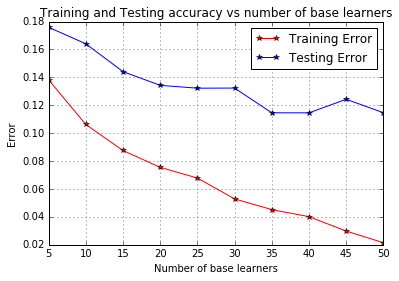

In [29]:
plt.figure()
plt.title("Training and Testing accuracy vs number of base learners")
plt.xlabel("Number of base learners")
plt.ylabel("Error")
plt.grid()
plt.plot(np.array([5,10,15,20,25,30,35,40,45,50]), np.mean(train,axis=0),'*-', color="r", label="Training Error")
plt.plot(np.array([5,10,15,20,25,30,35,40,45,50]), np.mean(test,axis=0), '*-', color="b", label="Testing Error")
plt.legend(loc="best")
plt.savefig('Boston50_Ada.jpg')
plt.show()

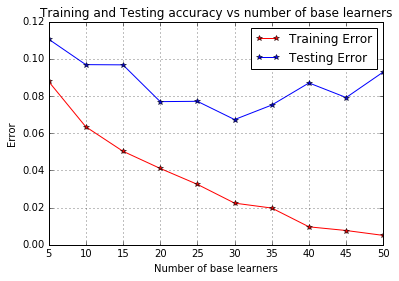

In [31]:
plt.figure()
plt.title("Training and Testing accuracy vs number of base learners")
plt.xlabel("Number of base learners")
plt.ylabel("Error")
plt.grid()
plt.plot(np.array([5,10,15,20,25,30,35,40,45,50]), np.mean(train75,axis=0),'*-', color="r", label="Training Error")
plt.plot(np.array([5,10,15,20,25,30,35,40,45,50]), np.mean(test75,axis=0), '*-', color="b", label="Testing Error")
plt.legend(loc="best")
plt.savefig('Boston75_Ada.jpg')
plt.show()